In [88]:
#Se importan las librerias necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, max_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.cluster import KMeans


In [2]:
#Se leen los datos
Datos = pd.read_csv('C:/Users/alvar/Documents/Maestria en Ciencia de datos/Aprendizaje automatico/Tareas/Tarea 1/typed_uanl.csv')

In [3]:
#Se modifica el conjunto de datos para obtener las agrupaciones que se desean para usar lo datos en los modelos:
sueldo_dependencia = Datos.groupby(["dependencia", "Fecha", "Tipo"])[["Sueldo Neto"]].agg({'Sueldo Neto': ['sum', 'count', 'mean']})
sueldo_dependencia.reset_index(inplace=True)
sueldo_dependencia.columns = ['dependencia','fecha', 'tipo', 'sueldo_neto', 'num_empleados', 'media_pago']
sueldo_dependencia['Pago_Diario_promedio'] = (sueldo_dependencia['media_pago']*12)/365
sueldo_dependencia["fecha"] = pd.to_datetime(sueldo_dependencia["fecha"])
sueldo_dependencia['año'] = sueldo_dependencia['fecha'].dt.year
sueldo_dependencia = sueldo_dependencia.loc[sueldo_dependencia['año'] != 2024]
sueldo_dependencia = sueldo_dependencia.groupby(["dependencia", "tipo"]).agg({'media_pago': ['mean'], 'num_empleados': 'mean', 'Pago_Diario_promedio': 'mean' })
sueldo_dependencia.reset_index(inplace=True)
sueldo_dependencia.columns = ['dependencia', 'tipo', 'sueldo_neto', 'num_empleados', 'pago_diario_promedio']
sueldo_dependencia['num_empleados'] = round(sueldo_dependencia['num_empleados'])


In [5]:
#Se mantienen las columnas para el primer modelo de regresión
model1 = sueldo_dependencia.drop(['dependencia', 'sueldo_neto', 'tipo'], axis = 1, inplace = False)
print(model1.describe())

       num_empleados  pago_diario_promedio
count     152.000000            152.000000
mean       90.500000            493.435701
std       205.951097            148.392815
min         1.000000            289.052966
25%        14.750000            416.354440
50%        37.000000            471.727384
75%       103.500000            533.596633
max      2202.000000           1422.072986


In [8]:
#Se separan los datos en X y Y
model1_x = model1.drop(['num_empleados'], axis = 1, inplace = False)
model1_y = model1.drop(['pago_diario_promedio'], axis = 1, inplace = False)

In [10]:
#Se entrena el primer modelo
model1_xtrain, model1_xtest, model1_ytrain, model1_ytest = train_test_split(model1_x, model1_y, test_size=0.2, random_state=73)
model1_knn_regressor = KNeighborsRegressor(n_neighbors=5)
model1_knn_regressor.fit(model1_xtrain, model1_ytrain)

KNeighborsRegressor()

In [11]:
#Se hace una la predicción de los datos de prueba y se obtiene la evaluación del modelo
model1_ypred = model1_knn_regressor.predict(model1_xtest)
model1_mse = mean_squared_error(model1_ytest, model1_ypred)
model1_r2 = r2_score(model1_ytest, model1_ypred)
print('MSE: '+ str(model1_mse))
print('R2 Score: ' + str(model1_r2))

MSE: 43367.32387096775
R2 Score: -1.093764766653937


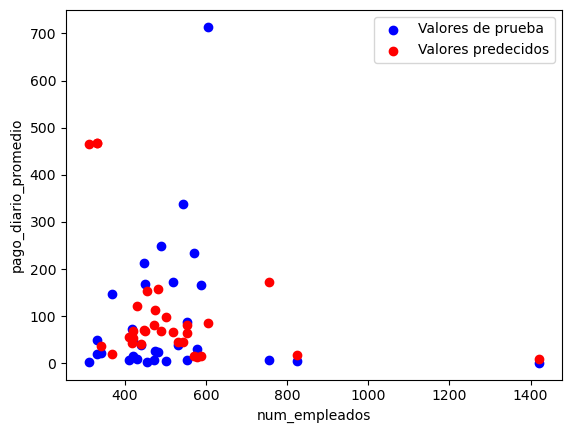

In [96]:
#Se grafican los resultados obtenidos contra los predichos
plt.scatter(model1_xtest, model1_ytest, color='blue', label = 'Valores de prueba')
plt.scatter(model1_xtest, model1_ypred, color='red', label = 'Valores predecidos')
plt.xlabel("num_empleados")
plt.ylabel("pago_diario_promedio")
plt.legend()

In [13]:
#Como la grafica anterior muestra muchos datos se decidio hacer un segundo modelo solo tomando en cuenta las preparatorias y no todas las dependencias
model2 = sueldo_dependencia.loc[sueldo_dependencia['tipo'] == 'PREPARATORIA']
model2 = model2.drop(['dependencia', 'sueldo_neto', 'tipo'], axis = 1, inplace = False)
model2_x = model2.drop(['num_empleados'], axis = 1, inplace = False)
model2_y = model2.drop(['pago_diario_promedio'], axis = 1, inplace = False)



In [15]:
#Se entrena el modelo
model2_xtrain, model2_xtest, model2_ytrain, model2_ytest = train_test_split(model2_x, model2_y, test_size=0.2, random_state=73)
model2_knn_regressor = KNeighborsRegressor(n_neighbors=5)
model2_knn_regressor.fit(model2_xtrain, model2_ytrain)

KNeighborsRegressor()

In [16]:
#Se realiza la predicción y se obtiene la evaluación del modelo
model2_ypred = model2_knn_regressor.predict(model2_xtest)
model2_mse = mean_squared_error(model2_ytest, model2_ypred)
model2_r2 = r2_score(model2_ytest, model2_ypred)
print('MSE: '+ str(model2_mse))
print('R2 Score: ' + str(model2_r2))

MSE: 27518.02666666667
R2 Score: -0.2964505237369852


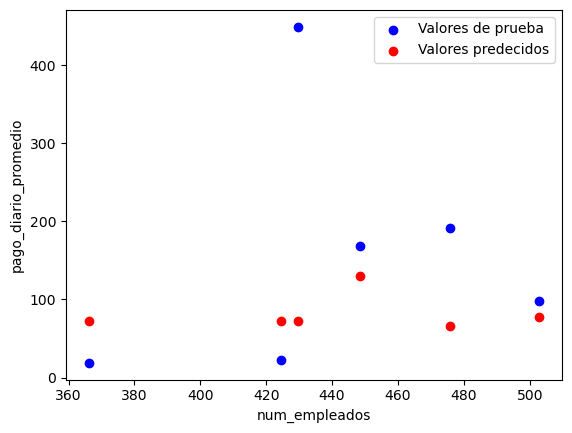

In [95]:
#Se grafican los resultados origuinales contra los predichos
plt.scatter(model2_xtest, model2_ytest, color='blue', label = 'Valores de prueba')
plt.scatter(model2_xtest, model2_ypred, color='red', label = 'Valores predecidos')
plt.xlabel("num_empleados")
plt.ylabel("pago_diario_promedio")
plt.legend()

In [43]:
#Se usarán los datos anteriores para encontrar el mejor modelo usando la validación cruzada, primero se4 hace el modelo y los parametris a probar
knn_vc = KNeighborsRegressor()
knn_vc_para = [{'n_neighbors': [1,2,4,6,8], 'weights':['uniform', 'distance']}]

In [97]:
#Se define el modelo para la validación cruzada y se obtiene el mejor modelo
best_knn_vc = GridSearchCV(knn_vc, knn_vc_para, cv=5, scoring='neg_mean_squared_error')

best_knn_vc.fit(model2_xtrain, model2_ytrain)
print(best_knn_vc.best_params_)
print(best_knn_vc.best_score_)

{'n_neighbors': 6, 'weights': 'uniform'}
-5538.8741666666665
